In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

In [7]:
Tickers = ['MSFT', 'MGM', 'AXL','AMZN']
Weights = np.array([0.25, 0.25, 0.25, 0.25])
Confidence_level = 0.95
Start_date = '2020-01-01'
End_date = '2023-01-01'
Num_simulation = 10000
Forecast_horizon = 1

In [8]:
def fetch_data(tickers, start_date, end_date):
    df = yf.download(tickers, start=start_date, end=end_date)['Close']
    log_returns = np.log(df / df.shift(1)).dropna()
    return log_returns

def cal_portfolio_metrics(log_returns, weights):

    weights = np.array(weights)
    if not np.isclose(np.sum(weights), 1.0):
        weights /= np.sum(weights)

    weights_series = pd.Series(weights, index=log_returns.columns)
    portfolio_returns = log_returns.dot(weights_series)

    portfolio_mean = portfolio_returns.mean()
    portfolio_std = portfolio_returns.std()

    return {
      'mean': portfolio_mean,
      'std': portfolio_std,
      'returns': portfolio_returns
    }

def calc_historical_VaR(portfolio_returns, confidence_level=0.05):
  VaR = -np.percentile(portfolio_returns, (1-confidence_level)*100)
  return VaR

def calc_parametric_VaR(portfolio_mean, portfolio_std, confidence_level):
  ZScore = -norm.ppf(1 - confidence_level)
  return portfolio_mean + ZScore * portfolio_std

def monte_carlo_var(portfolio_returns, confidence_level, num_simulations, forecast_horizon):

    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()

    initial_portfolio_value = 1.0

    random_returns = np.random.normal(mu, sigma, (forecast_horizon, num_simulations))

    simulated_paths = np.zeros((forecast_horizon + 1, num_simulations))
    simulated_paths[0] = initial_portfolio_value

    for t in range(1, forecast_horizon + 1):
        simulated_paths[t] = simulated_paths[t-1] * np.exp(random_returns[t-1])

    final_values = simulated_paths[-1, :]

    var_percentile = (1 - confidence_level) * 100
    var_value = np.percentile(final_values, var_percentile)

    monte_carlo_var = initial_portfolio_value - var_value

    return{
        'monte_carlo_var': monte_carlo_var,
          'final_values': final_values
    }

def visualize_var(metrics, historical_var, parametric_var, monte_carlo_var, final_simulated_values, confidence_level):
    returns = metrics['returns']
    mean = metrics['mean']
    std = metrics['std']

    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    returns.cumsum().plot()
    plt.title("Portfolio Cumulative Log Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")

    plt.subplot(3, 2, 2)
    sns.histplot(returns, bins=50, kde=True, color='skyblue')
    plt.axvline(-historical_var, color='red', linestyle='--', label=f"Historical VaR ({confidence_level*100:.0f}%)")
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(3, 2, 3)
    x = np.linspace(mean - 4*std, mean + 4*std, 1000)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label='Normal Distribution')
    plt.axvline(parametric_var, color='orange', linestyle='--', label=f"Parametric VaR ({confidence_level*100:.0f}%)")
    plt.title("Normal Distribution with Parametric VaR")
    plt.xlabel("Daily Return")
    plt.ylabel("Density")
    plt.legend()

    plt.subplot(3, 2, 4)
    sns.histplot(final_simulated_values, bins=50, color='lightgreen')
    plt.axvline(1 - monte_carlo_var, color='purple', linestyle='--', label='Monte Carlo VaR Cutoff')
    plt.title("Monte Carlo Simulation of Final Portfolio Value")
    plt.xlabel("Final Value")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(3, 2, 5)
    returns.rolling(window=30).std().plot()
    plt.title("30-Day Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")

    plt.tight_layout()
    plt.show()

def run_var_analysis(tickers, weights, start_date, end_date, confidence_level, num_simulations, forecast_horizon):
    log_returns = fetch_data(tickers, start_date, end_date)
    metrics = cal_portfolio_metrics(log_returns, weights)

    historical_VaR = calc_historical_VaR(metrics['returns'], confidence_level)
    parametric_VaR = calc_parametric_VaR(metrics['mean'], metrics['std'], confidence_level)
    monte_carlo = monte_carlo_var(metrics['returns'], confidence_level, num_simulations, forecast_horizon)

    visualize_var(metrics, historical_VaR, parametric_VaR, monte_carlo['monte_carlo_var'], monte_carlo['final_values'], confidence_level)

    results = {
        'log_returns': log_returns,
        'metrics': metrics,
        'VaR': {
            'historical': historical_VaR,
            'parametric': parametric_VaR,
            'monte_carlo': monte_carlo['monte_carlo_var']
        },
        'simulated_values': monte_carlo['final_values']
    }

    return results

C:\Users\Mudassir\AppData\Local\Temp\ipykernel_14488\1927400487.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


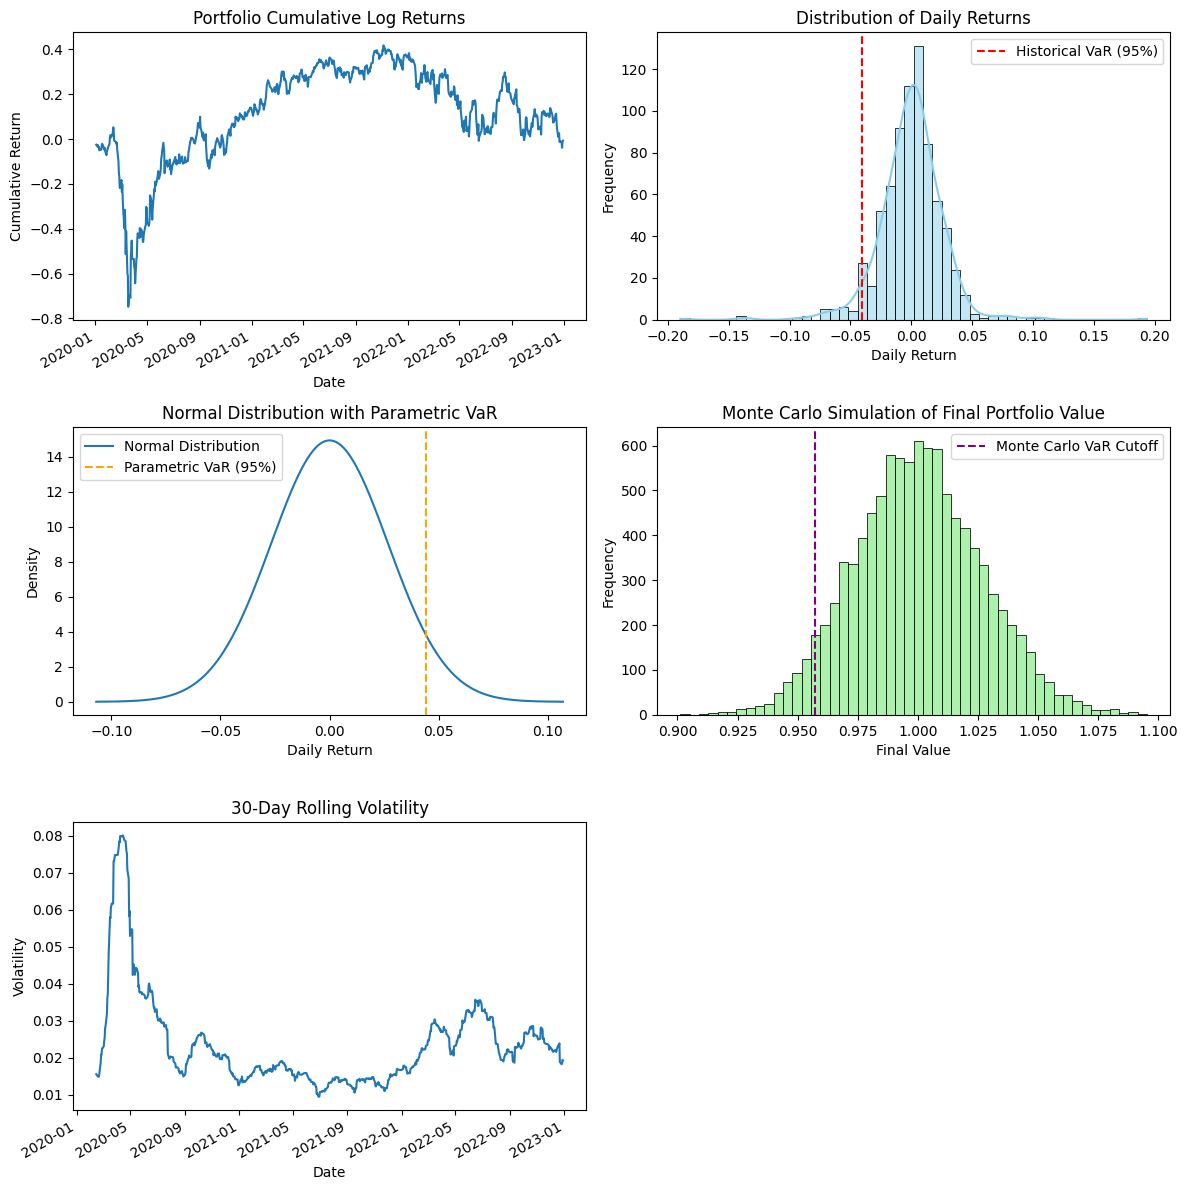

In [9]:
results = run_var_analysis(
    tickers=Tickers,
    weights=Weights,
    start_date=Start_date,
    end_date=End_date,
    confidence_level=Confidence_level,
    num_simulations=Num_simulation,
    forecast_horizon=Forecast_horizon
)

In [10]:
display(results['log_returns'].head())
print('Portfolio Daily Returns (First 5):')
print((results['metrics']['returns'] * 100).head())
print('Portfolio Mean Return:', results['metrics']['mean'] * 100)
print('Portfolio Volatility:', results['metrics']['std'] * 100)
print('--- Value at Risk ---')
print('Historical VaR:', results['VaR']['historical'] * 100)
print('Parametric VaR:', results['VaR']['parametric'] * 100)
print('Monte Carlo VaR:', results['VaR']['monte_carlo'] * 100)

Ticker,AMZN,AXL,MGM,MSFT
Date,,,,
2020-01-03,-0.012213,-0.063020,-0.011053,-0.012530
2020-01-06,0.014776,-0.037591,-0.012088,0.002582
2020-01-07,0.002089,0.029794,0.000608,-0.009160
2020-01-08,-0.007839,-0.058425,0.009978,0.015803
2020-01-09,0.004788,-0.013577,0.005999,0.012415


Portfolio Daily Returns (First 5):
Date
2020-01-03   -2.470420
2020-01-06   -0.808048
2020-01-07    0.583281
2020-01-08   -1.012110
2020-01-09    0.240612
dtype: float64
Portfolio Mean Return: -0.0008920087231223468
Portfolio Volatility: 2.672712867514276
--- Value at Risk ---
Historical VaR: 4.016364386103925
Parametric VaR: 4.395329445207604
Monte Carlo VaR: 4.280980210365303
